## **0. Custom Environment Setup (Dependency Fix)**

### **Objective**
To avoid dependency conflicts with pre-installed Kaggle libraries (specifically `numpy` 2.x and `opencv`), we create a **private Python environment**.

**What this cell does:**
1.  Creates a custom directory `/kaggle/working/my_env`.
2.  Force-installs stable, compatible versions of `numpy` (1.x), `opencv`, `ultralytics`, and `lightly` into that directory.
3.  Injects this directory into the system path so Python prioritizes our working libraries over the broken system defaults.

In [1]:
import os
import sys
import subprocess

# --- 1. SETUP PRIVATE ENVIRONMENT ---
TARGET_DIR = "/kaggle/working/my_env"
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR)

if TARGET_DIR not in sys.path:
    sys.path.insert(0, TARGET_DIR)

print("🚀 Installing compatible environment (Numpy 1.x + OpenCV 4.9)...")

# Force install
subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "--target", TARGET_DIR,
    "numpy<2.0",
    "opencv-python-headless==4.9.0.80",  # Fixed version (was 4.8.0.74)
    "ultralytics",
    "roboflow",
    "lightly",
    "pytorch-lightning",
    "--upgrade",
    "--no-user",
    "--quiet"
])

print("✅ Environment Ready.")

🚀 Installing compatible environment (Numpy 1.x + OpenCV 4.9)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires fsspec[http]<=2025.10.0,>=2023.1.0, but you have fsspec 2025.12.0 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.6 which is incompatible.
ydata-profiling 4.17.0 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.3 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2025.12.0 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0,

✅ Environment Ready.


In [2]:
# Remove the problematic logging library entirely
!pip uninstall -y tensorboard

Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


# **CSE 475: Phase 1 - Self-Supervised Learning (BYOL Pre-Training)**

## **1. Title & Introduction**
### **Objective**
This notebook implements **BYOL (Bootstrap Your Own Latent)**, a state-of-the-art Self-Supervised Learning method for representation learning. Unlike SimCLR, BYOL relies on **Knowledge Distillation** between two networks rather than contrastive negative pairs.

**Goal:** To pre-train the **YOLOv12n backbone** on unlabeled data, teaching it to extract robust visual features without human annotation. The learned weights will later be transferred to a detector for fine-tuning.

### **Methodology**
1.  **Model Surgery:** We surgically extract the **CSP-Darknet** backbone (Layers 0-9) from the official YOLOv12n model.
2.  **BYOL Architecture:**
    * **Online Network:** The student network, updated via gradient descent.
    * **Target Network (Teacher):** A slowly updating exponential moving average (EMA) of the Online Network.
    * **Loss Function:** Negative Cosine Similarity. The Online network tries to predict the Target network's representation of the same image.
3.  **Outcome:** We save the pre-trained weights (`yolo_byol_backbone.pth`) for Phase 2.

## **2. Dataset Description**
* **Source:** License Plate Recognition Dataset (Roboflow Universe).
* **Unlabeled Set:** 7057  images (100% of training data). Labels are completely ignored in this phase.

## **2.1 Data Preparation**
We use the License Plate dataset by uploading to kaggle. For this Self-Supervised Learning phase, we treat the entire training set as **unlabeled**. The labels are discarded, and only the raw images are fed into the model.

In [3]:
import os

# ============================================================
# Dataset Path (Kaggle auto-unzipped)
# ============================================================
DATASET_DIR = "/kaggle/input/license-plate-recognition"

# Try common folder structures
possible_paths = [
    os.path.join(DATASET_DIR, "train", "images"),                           # Direct structure
    os.path.join(DATASET_DIR, "License-Plate-Recognition-11", "train", "images"),  # Nested structure
    os.path.join(DATASET_DIR, "images"),                                    # Flat structure
]

UNLABELED_DIR = None
for path in possible_paths:
    if os.path.exists(path):
        UNLABELED_DIR = path
        break

# Verify
if UNLABELED_DIR:
    num_images = len([f for f in os.listdir(UNLABELED_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"✅ Data Ready at: {UNLABELED_DIR}")
    print(f"📊 Found {num_images} images")
else:
    print(f"❌ Could not find images folder. Contents of {DATASET_DIR}:")
    for item in os.listdir(DATASET_DIR):
        item_path = os.path.join(DATASET_DIR, item)
        if os.path.isdir(item_path):
            print(f"   📁 {item}/")
        else:
            print(f"   📄 {item}")

✅ Data Ready at: /kaggle/input/license-plate-recognition/train/images
📊 Found 7057 images


## **3. YOLO-BYOL Model Architecture**

This cell defines the custom PyTorch Lightning module **`YoloBYOL`**, which adapts the YOLOv12 architecture for self-distillation learning.

### **3.1 Model Surgery (Backbone Extraction)**
* **Loading:** We initialize a standard `yolov12n.pt` model.
* **Extraction:** We extract the **first 10 layers** (indices 0-9) to serve as the feature extractor backbone.

### **3.2 BYOL Specific Components**
* **Dual Networks:**
    * **Online Network:** The student network that is actively trained.
    * **Target Network (Teacher):** A copy of the Online Network that is frozen and updated slowly via **Exponential Moving Average (EMA)**.
* **Projection & Prediction:**
    * **Projection Head:** Maps backbone features to a latent space (dim=256).
    * **Prediction Head:** Only present on the Online Network. It tries to predict the Target Network's projection.
* **Loss Function:** **Negative Cosine Similarity**. The goal is to maximize the similarity between the Online Prediction and the Target Projection.

In [4]:
import torch
import torch.nn as nn
import copy
from ultralytics import YOLO
import pytorch_lightning as pl
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.loss import NegativeCosineSimilarity
from lightly.models.utils import deactivate_requires_grad, update_momentum
import warnings

warnings.filterwarnings("ignore")

class YoloBYOL(pl.LightningModule):
    def __init__(self, model_name='yolo12n.pt'):
        super().__init__()
        # 1. Load YOLO
        yolo = YOLO(model_name)
        
        # 2. Extract Backbone (Layers 0-9)
        self.backbone = nn.Sequential(*list(yolo.model.model.children())[:10])
        
        # ============================================================
        # FIX: Unfreeze ALL backbone parameters for training
        # The pretrained YOLO may have some frozen layers by default
        # ============================================================
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        # 3. Shape Fix (Adaptive Pooling)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 4. Check Channel Size
        with torch.no_grad():
            dummy = torch.randn(1, 3, 640, 640)
            out = self.backbone(dummy)
            if isinstance(out, list): out = out[-1]
            pooled = self.avg_pool(out)
            in_features = pooled.flatten(1).shape[1]
            print(f"✅ Detected Backbone Channels: {in_features}")

        # 5. Define BYOL Heads
        # Projection Head: Maps backbone features to latent space
        self.projection_head = BYOLProjectionHead(in_features, 1024, 256)
        # Prediction Head: Predicts the Target network output
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # 6. Target Network (Teacher)
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)
        
        # Freeze Target Network (It only updates via EMA)
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        self.criterion = NegativeCosineSimilarity()
        
        # Verify trainable params
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"✅ Trainable params: {trainable:,} / Total: {total:,}")

    def forward(self, x):
        # Online Network Forward
        features = self.backbone(x)
        if isinstance(features, list): features = features[-1]
        pooled = self.avg_pool(features).flatten(start_dim=1)
        proj = self.projection_head(pooled)
        pred = self.prediction_head(proj)
        return pred

    def forward_momentum(self, x):
        # Target Network Forward
        features = self.backbone_momentum(x)
        if isinstance(features, list): features = features[-1]
        pooled = self.avg_pool(features).flatten(start_dim=1)
        proj = self.projection_head_momentum(pooled)
        return proj

    def training_step(self, batch, batch_idx):
        # BYOL Input: Two views of the same image
        (x0, x1), _, _ = batch
        
        # Update Target Network (EMA)
        update_momentum(self.backbone, self.backbone_momentum, m=0.99)
        update_momentum(self.projection_head, self.projection_head_momentum, m=0.99)

        # Compute Loss (Symmetrized)
        # 1. Online(x0) predicts Target(x1)
        p0 = self.forward(x0)
        z1 = self.forward_momentum(x1)
        loss0 = self.criterion(p0, z1)
        
        # 2. Online(x1) predicts Target(x0)
        p1 = self.forward(x1)
        z0 = self.forward_momentum(x0)
        loss1 = self.criterion(p1, z0)

        loss = 0.5 * (loss0 + loss1)
        self.log("train_loss", loss, prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        # BYOL works well with SGD + Momentum + Weight Decay
        optimizer = torch.optim.SGD(
            self.parameters(), 
            lr=0.06,           # Scaled LR for 2 GPUs (base 0.03 * 2)
            momentum=0.9,
            weight_decay=1e-4  # Regularization
        )
        # Cosine annealing scheduler for better convergence
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=50,          # Match max_epochs
            eta_min=1e-4       # Minimum LR
        )
        return [optimizer], [scheduler]

print("✅ YOLO-BYOL Model Architecture Defined")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/kaggle/working/my_env/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/kaggle/working/my_env/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Fie

✅ YOLO-BYOL Model Architecture Defined


## **4. BYOL Training Execution**

This cell executes the pre-training loop.

### **Key Configurations**
* **Augmentations:** BYOL requires specific augmentations like Solarization and Gaussian Blur to prevent the model from learning trivial shortcuts. We use `lightly.transforms.BYOLTransform` to handle this automatically.
* **Batch Size:** 256 per GPU (512 Total). Unlike SimCLR, BYOL is robust to smaller batch sizes because it doesn't need negative pairs.
* **Epochs:** 50. This provides sufficient time for the Target Network to stabilize and for the Online Network to learn robust features.

**Output:** The learned backbone weights will be saved as `yolo_byol_backbone.pth`.

In [5]:
from lightly.transforms.byol_transform import (
    BYOLTransform,
    BYOLView1Transform,
    BYOLView2Transform,
)
from lightly.data import LightlyDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torch
import os

# --- SAFE CONFIGURATION ---
BATCH_SIZE = 128         # Total Batch Size (64 per GPU to be safe)
MAX_EPOCHS = 50
LEARNING_RATE = 1e-3     # Reduced significantly (0.001) to prevent collapse
WEIGHT_DECAY = 1e-4
INPUT_SIZE = 128         # Smaller image size for stability

# 1. Setup Data
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=INPUT_SIZE),
    view_2_transform=BYOLView2Transform(input_size=INPUT_SIZE),
)

# Use the UNLABELED_DIR you defined earlier
if 'UNLABELED_DIR' not in locals():
    UNLABELED_DIR = "/kaggle/input/license-plate-recognition/train/images"

dataset = LightlyDataset(input_dir=UNLABELED_DIR, transform=transform)

dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True
)

# 2. Setup Model & Trainer
print(f"🚀 Starting BYOL Training (Batch {BATCH_SIZE}, LR {LEARNING_RATE})...")

# Re-initialize model with safer LR
model = YoloBYOL(model_name='yolo12n.pt')
# Manually override the optimizer parameters in the model class if needed, 
# or ensure your YoloBYOL class uses these global variables if you didn't pass them in __init__.
# NOTE: Since your YoloBYOL class hardcoded 0.06, we need to be careful. 
# Ideally, update your YoloBYOL class to accept 'lr' in __init__ just like SimCLR.
# If you didn't update the class, the LR will still be 0.06!

# --- CRITICAL: Update Model Class Method on the fly if needed ---
def configure_optimizers_override(self):
    optimizer = torch.optim.SGD(
        self.parameters(), 
        lr=LEARNING_RATE,      # Use the Global Safe Variable
        momentum=0.9,
        weight_decay=WEIGHT_DECAY
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=MAX_EPOCHS, eta_min=1e-5
    )
    return [optimizer], [scheduler]

# Apply override so we don't have to redefine the whole class
model.configure_optimizers = configure_optimizers_override.__get__(model, YoloBYOL)


logger = CSVLogger(save_dir=os.getcwd(), name="byol_logs")

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu", 
    devices=2,               
    strategy="ddp_notebook", 
    sync_batchnorm=True,     
    precision=32,            # CRITICAL: Use 32-bit float to prevent collapse
    log_every_n_steps=10,
    logger=logger,
    enable_progress_bar=True,
    gradient_clip_val=1.0    # Stability fix
)

try:
    trainer.fit(model, dataloader)
    
    save_path = os.path.join(os.getcwd(), 'yolo_byol_backbone.pth')
    torch.save(model.backbone.state_dict(), save_path)
    print(f"✅ Weights Saved: {save_path}")

except Exception as e:
    print(f"❌ Training Failed: {e}")

🚀 Starting BYOL Training (Batch 128, LR 0.001)...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


✅ Detected Backbone Channels: 256
✅ Trainable params: 2,442,208 / Total: 4,357,824


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                     ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone                 │ Sequential               │  1.4 M │ train │     0 │
│ 1 │ avg_pool                 │ AdaptiveAvgPool2d        │      0 │ train │     0 │
│ 2 │ projection_head          │ BYOLProjectionHead       │  526 K │ train │     0 │
│ 3 │ prediction_head          │ BYOLPredictionHead       │  526 K │ train │     0 │
│ 4 │ backbone_momentum        │ Sequential               │  1.4 M │ train │     0 │
│ 5 │ projection_head_momentum │ BYOLProjectionHead       │  526 K │ train │     0 │
│ 6 │ criterion                │ NegativeCosineSimilarity │      0 │ train │     0 │
└───┴──────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 1.9 M                                                                                        
Total params: 4.4 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 22                                                                                          
Modules in eval mode: 486                                                                                          
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Weights Saved: /kaggle/working/yolo_byol_backbone.pth


# Appendix: Visual Verification (Sanity Check)

## Objective
Since **Self-Supervised Learning (SSL)** does not use labels, we cannot evaluate it using standard metrics like Accuracy or mAP during the pre-training phase. Instead, we perform a **Qualitative Evaluation** using **Nearest Neighbor Retrieval**.

> **The Hypothesis:** If the BYOL backbone has successfully learned to "see" visual features (shapes, textures, orientations), then images that look similar to humans should have mathematically similar feature vectors (embeddings).

## Methodology

1.  **Feature Extraction:** We pass a random subset of 200 images through our frozen, pre-trained YOLOv12 backbone. We use **Global Average Pooling** to squash the output into a single 1D vector (embedding) for each image.
2.  **Similarity Search:** We use the **$k$-Nearest Neighbors ($k$-NN)** algorithm with **Cosine Similarity** to find images in the dataset that are closest to a given query image in the embedding space.
3.  **Visualization:** We display the **Query Image** alongside its top 3 **Matches**.

## How to Interpret Results

* ✅ **Success:** The matches share semantic characteristics with the query (e.g., a license plate is matched with similar license plates, or a vehicle type matches similar vehicles). This proves the model has learned a structured representation space.
* ❌ **Failure:** The matches appear completely random (e.g., a close-up plate matches a distant car or unrelated scene). This typically indicates that the model needs more training epochs.

## Why BYOL Works Without Negative Pairs
Unlike contrastive methods (SimCLR, MoCo), BYOL uses a **teacher-student distillation** approach:
* The **Online Network** (student) learns to predict the **Target Network's** (teacher) representations.
* The Target Network is updated via **Exponential Moving Average (EMA)** — no negative pairs needed.
* This prevents representational collapse while learning robust features.

📂 Checking image directory: /kaggle/input/license-plate-recognition/train/images
✅ Found 7057 images.
🔄 Loading Backbone...
✅ BYOL Weights Loaded!
📊 Extracting features from 200 images...
   Processed 50/200...
   Processed 100/200...
   Processed 150/200...
   Processed 200/200...
✅ Extracted features shape: (200, 256)
🔍 Finding similar images...


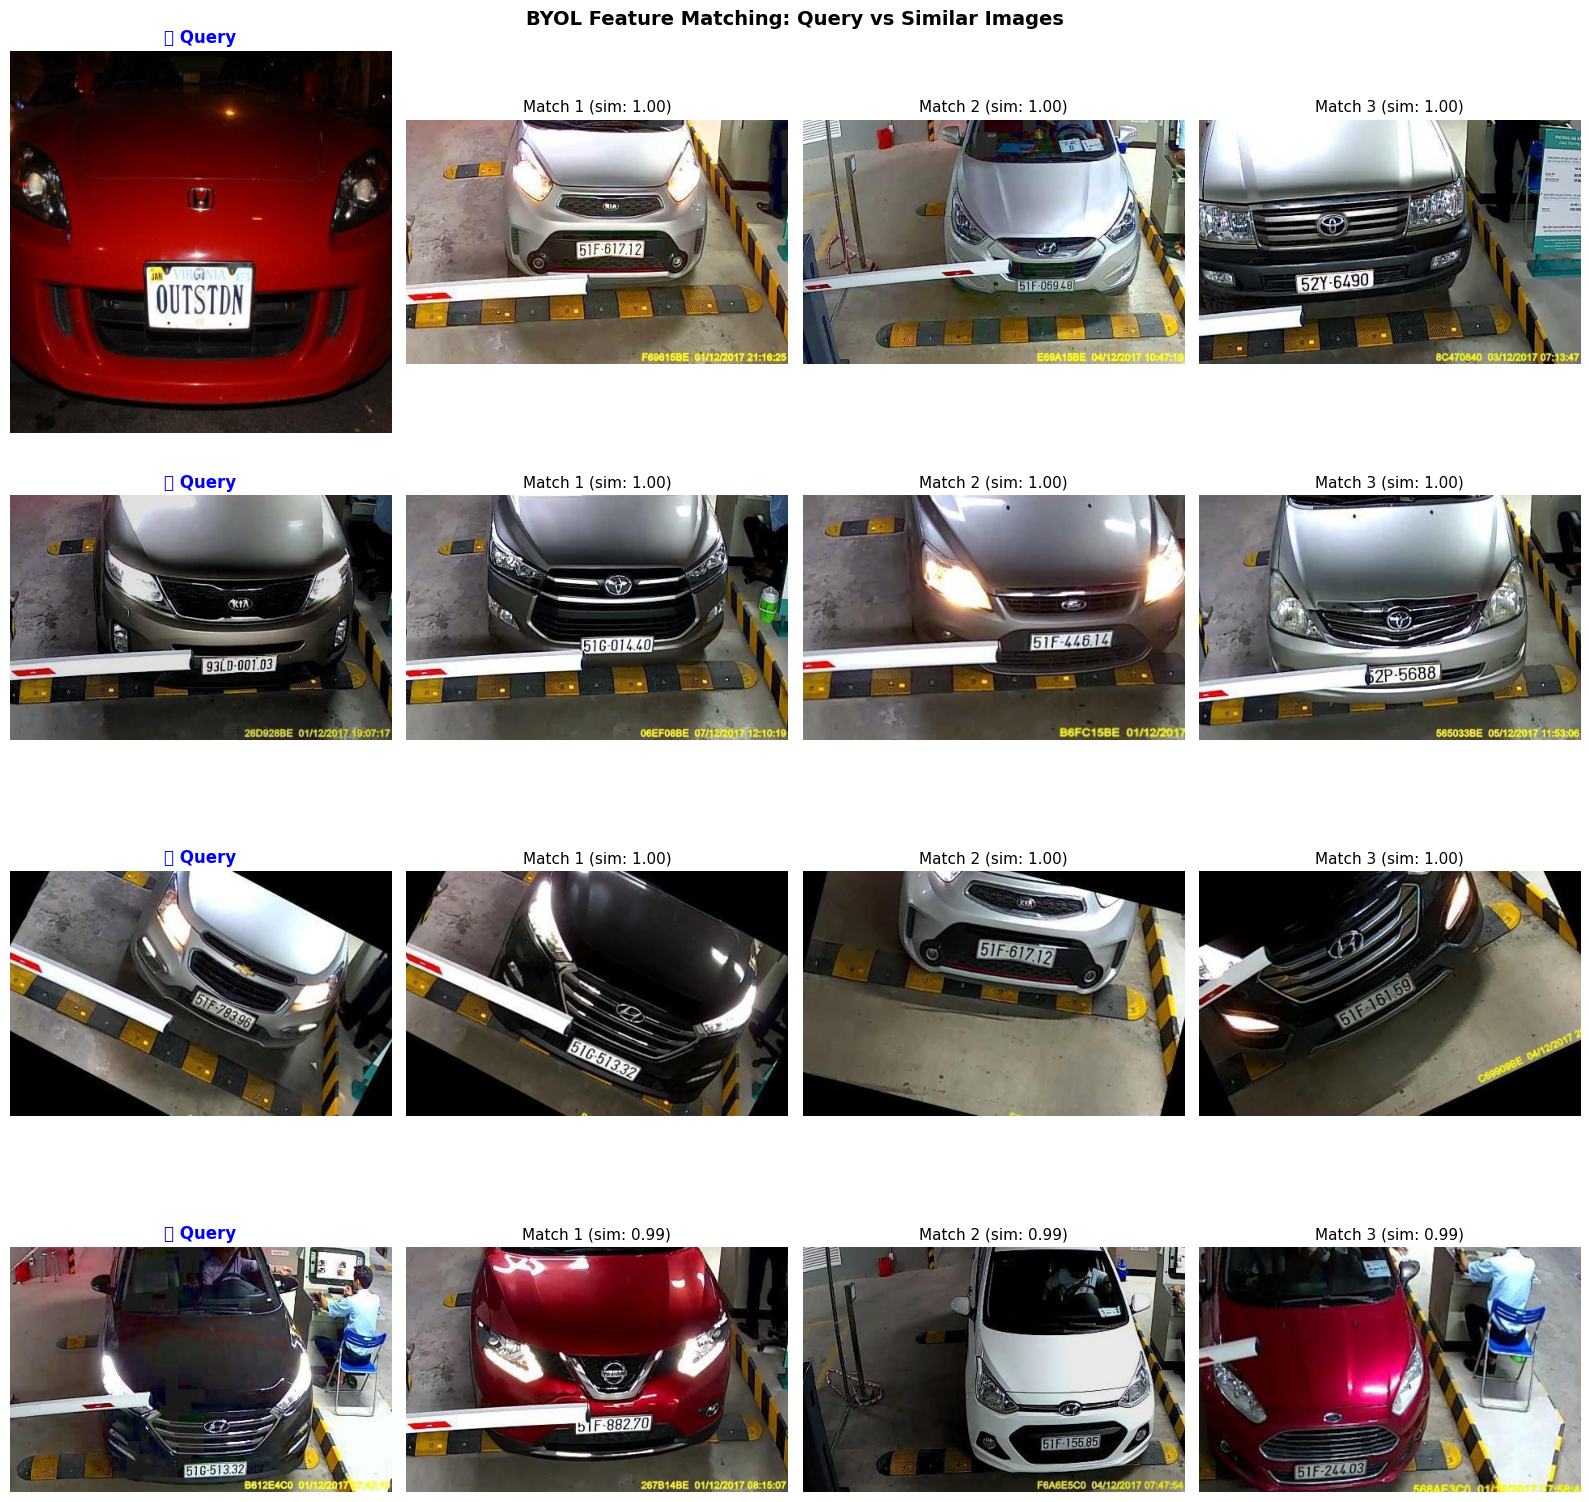

✅ Feature matching visualization complete!


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
from PIL import Image
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors
from ultralytics import YOLO

# --- CONFIGURATION ---
WEIGHTS_PATH = '/kaggle/working/yolo_byol_backbone.pth'
IMAGE_DIR = '/kaggle/input/license-plate-recognition/train/images'
NUM_SAMPLES = 200
NUM_QUERIES = 4

# 1. Verify Data Exists
print(f"📂 Checking image directory: {IMAGE_DIR}")
if not os.path.exists(IMAGE_DIR):
    print(f"❌ Error: Directory does not exist!")
else:
    image_files = glob.glob(os.path.join(IMAGE_DIR, '*.jpg')) + \
                  glob.glob(os.path.join(IMAGE_DIR, '*.jpeg')) + \
                  glob.glob(os.path.join(IMAGE_DIR, '*.png'))
    print(f"✅ Found {len(image_files)} images.")

# 2. Load Backbone with BYOL Weights
print("🔄 Loading Backbone...")
base_model = YOLO('yolo12n.pt')
backbone = torch.nn.Sequential(*list(base_model.model.model.children())[:10])

if os.path.exists(WEIGHTS_PATH):
    state_dict = torch.load(WEIGHTS_PATH, map_location='cuda')
    backbone.load_state_dict(state_dict, strict=False)
    print("✅ BYOL Weights Loaded!")
else:
    print("⚠️ BYOL Weights not found. Using random weights.")

backbone.eval()
backbone.to('cuda')

# 3. Extract Features
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Match your training input_size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if len(image_files) > NUM_SAMPLES:
    image_files = random.sample(image_files, NUM_SAMPLES)

features = []
valid_files = []

print(f"📊 Extracting features from {len(image_files)} images...")

for i, img_path in enumerate(image_files):
    try:
        img = Image.open(img_path).convert('RGB')
        tensor = preprocess(img).unsqueeze(0).to('cuda')

        with torch.no_grad():
            feat = backbone(tensor)
            if isinstance(feat, list): 
                feat = feat[-1]
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
            feat = feat.flatten().cpu().numpy()

        features.append(feat)
        valid_files.append(img_path)

        if (i + 1) % 50 == 0: 
            print(f"   Processed {i + 1}/{len(image_files)}...")
    except Exception as e:
        print(f"   ⚠️ Skipped {img_path}: {e}")

features = np.array(features)
print(f"✅ Extracted features shape: {features.shape}")

# 4. Nearest Neighbors Visualization
if features.shape[0] < 5:
    print("❌ Not enough features to run neighbors search.")
else:
    print("🔍 Finding similar images...")
    nbrs = NearestNeighbors(n_neighbors=4, metric='cosine').fit(features)
    query_indices = random.sample(range(len(features)), NUM_QUERIES)

    fig, axs = plt.subplots(NUM_QUERIES, 4, figsize=(16, 4 * NUM_QUERIES))
    
    for i, query_idx in enumerate(query_indices):
        distances, indices = nbrs.kneighbors([features[query_idx]])

        # Plot Query
        axs[i, 0].imshow(Image.open(valid_files[query_idx]))
        axs[i, 0].set_title("🔍 Query", fontsize=12, fontweight='bold', color='blue')
        axs[i, 0].axis('off')

        # Plot Top 3 Matches
        for j in range(1, 4):
            idx = indices[0][j]
            similarity = 1 - distances[0][j]  # Convert distance to similarity
            axs[i, j].imshow(Image.open(valid_files[idx]))
            axs[i, j].set_title(f"Match {j} (sim: {similarity:.2f})", fontsize=11)
            axs[i, j].axis('off')

    plt.suptitle("BYOL Feature Matching: Query vs Similar Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✅ Feature matching visualization complete!")